In [2]:
# import torch
#
# ckpt_path = "D:/programs/VoiceMark/train/Log/spt_base/WatermarkTrainer_00001000.pt"
# ckpt = torch.load(ckpt_path, map_location="cpu")
#
# print("🔎 Checkpoint type:", type(ckpt))
#
# if isinstance(ckpt, dict):
#     print("✅ Keys in checkpoint:")
#     for i, k in enumerate(ckpt.keys()):
#         print(f"  {i+1}. {k}")
#         if i >= 20:  # 最多只打印前 20 个 key
#             break
# else:
#     print("⚠️ Checkpoint is not a dict, type:", type(ckpt))

In [3]:
from example.watermark import embed_watermark, decode_watermark

🔄 Loading model weights from ../voicemark.pth...
✅ Model state dict loaded successfully.
   Missing keys: ['st_model.encoder.model.0.conv.conv.bias', 'st_model.encoder.model.0.conv.conv.parametrizations.weight.original0', 'st_model.encoder.model.0.conv.conv.parametrizations.weight.original1', 'st_model.encoder.model.1.block.1.conv.conv.bias', 'st_model.encoder.model.1.block.1.conv.conv.parametrizations.weight.original0', 'st_model.encoder.model.1.block.1.conv.conv.parametrizations.weight.original1', 'st_model.encoder.model.1.block.3.conv.conv.bias', 'st_model.encoder.model.1.block.3.conv.conv.parametrizations.weight.original0', 'st_model.encoder.model.1.block.3.conv.conv.parametrizations.weight.original1', 'st_model.encoder.model.1.shortcut.conv.conv.bias', 'st_model.encoder.model.1.shortcut.conv.conv.parametrizations.weight.original0', 'st_model.encoder.model.1.shortcut.conv.conv.parametrizations.weight.original1', 'st_model.encoder.model.3.conv.conv.bias', 'st_model.encoder.model.3.c

D:\programs\VoiceMark\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [4]:
from example.audio import load_audio, play_audio, plot_waveform_and_specgram
#
# waveform, sr = load_audio("../audios/1.wav", target_sr=16000)
# print(waveform.shape, sr)

In [5]:
import torch
import torchaudio
import urllib

def download_sample_audio():
    url = "https://keithito.com/LJ-Speech-Dataset/LJ037-0171.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())

    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

audio, sr = download_sample_audio()
print(audio.shape, sr)

torch.Size([1, 167226]) 22050


D:\programs\VoiceMark\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [6]:
# audio, sr = torchaudio.load("../audios/fake_audio.wav")

In [7]:
# import torch
#
# length = 72000
# num_gaps = 20
# gap_ratio = 0.02
# gap_length = int(length * gap_ratio)
# sr = 24000
#
# # 生成随机音频 [-0.1, 0.1]
# audio = (torch.rand(length) * 0.2 - 0.1).float()
#
# # 随机生成 5 处空白
# for _ in range(num_gaps):
#     start = torch.randint(0, length - gap_length, (1,)).item()
#     end = start + gap_length
#     audio[start:end] = 0.0
#
# audio = audio.unsqueeze(0)
#
# print(audio.shape)  # torch.Size([72000])

In [8]:
play_audio(audio, sr)

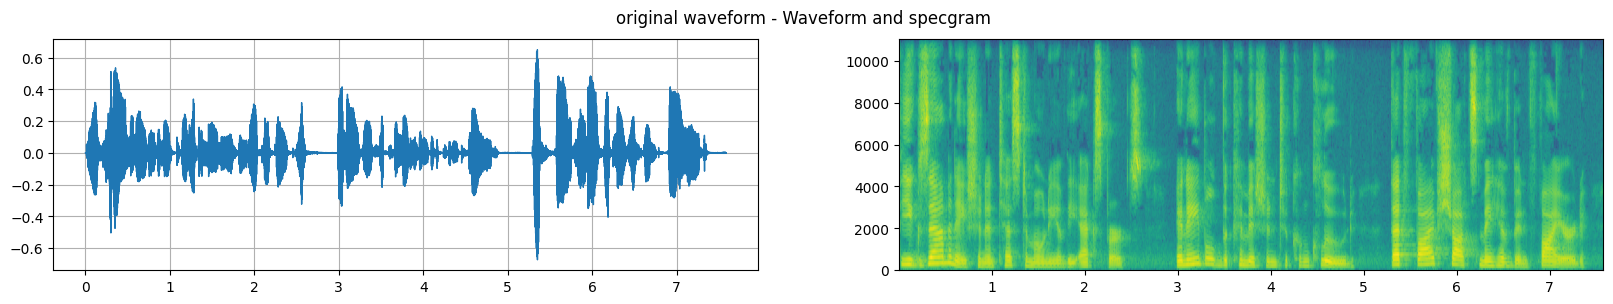


This is likely a watermarked audio: 0.0018776706419885159, message: 0000111001111111


In [9]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

plot_waveform_and_specgram(audio, sr, "original waveform")
result, message = decode_watermark(audio, sr)
print(f"\nThis is likely a watermarked audio: {result}, message: {message}")

In [10]:
watermarked_audio = embed_watermark(audio, sample_rate=sr, message="1000010101010011")
play_audio(watermarked_audio, 16000)

In [11]:
import soundfile as sf

# 保存
sf.write("watermarked_audio.wav", watermarked_audio.cpu().numpy().squeeze().astype('float32'), 16000)

# 读取回来
import librosa
audio_np, sr = librosa.load("watermarked_audio.wav", sr=16000)
# 转回 Tensor
watermarked_audio = torch.tensor(audio_np, dtype=torch.float32).unsqueeze(0)
print(watermarked_audio.shape)

torch.Size([1, 121344])


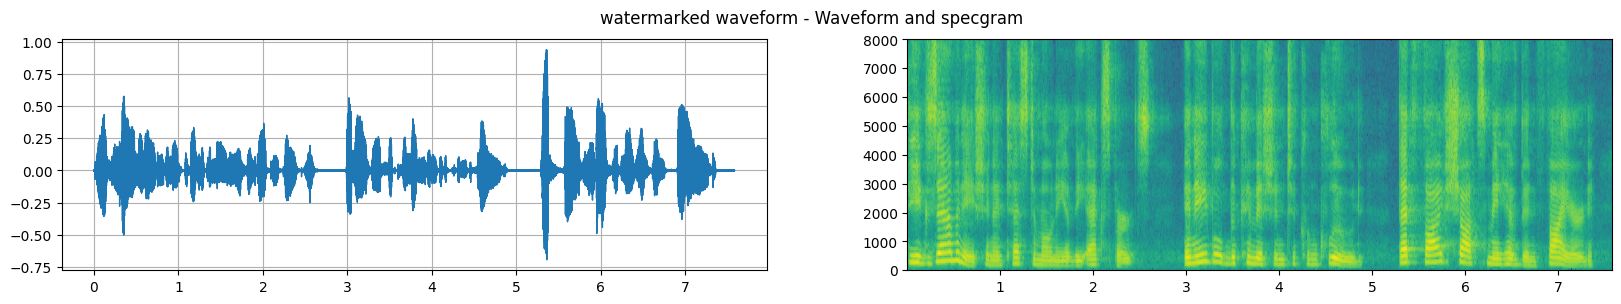


This is likely a watermarked audio: 0.8078639507293701, message: 1000010101010011


In [12]:
plot_waveform_and_specgram(watermarked_audio, 16000, "watermarked waveform")
result, message = decode_watermark(watermarked_audio, sr)
print(f"\nThis is likely a watermarked audio: {result}, message: {message}")

In [13]:
from example.attacks import AudioEffects as af

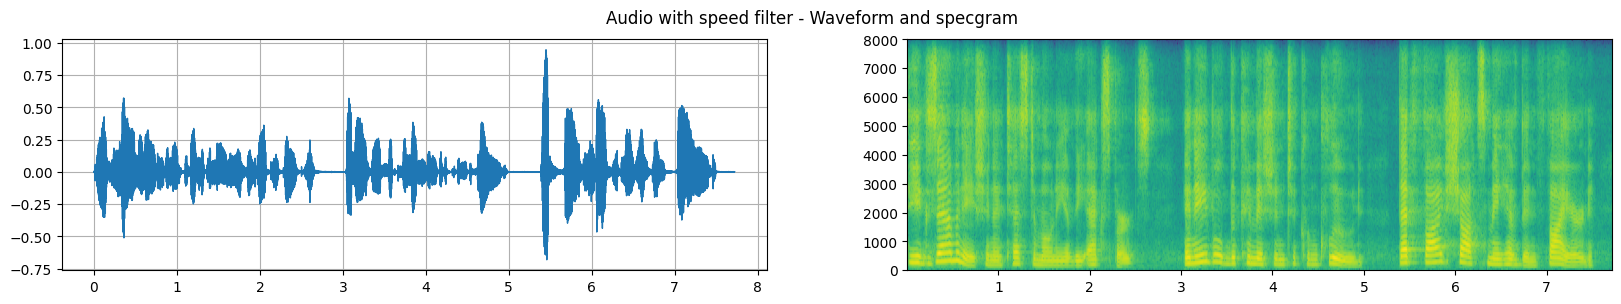

Detection Result with Speed Filter: (0.8689607381820679, '1011010110110011')


In [14]:
speed = af.speed(watermarked_audio, sample_rate=sr, speed_range=(0.9, 1.1))
plot_waveform_and_specgram(speed, sample_rate=sr, title="Audio with speed filter")
play_audio(speed, sr)
result, message = decode_watermark(speed, sr)
print(f"Detection Result with Speed Filter: {result, message}")

### pitch shift

In [15]:
import torch
import librosa
import numpy as np

def random_pitch_shift_tensor(audio_tensor, sr, n_semitones=5):
    """
    接受 PyTorch Tensor，返回 PyTorch Tensor
    """
    # 转 numpy
    audio_np = audio_tensor.cpu().numpy().squeeze(0)
    shift = np.random.uniform(-n_semitones, n_semitones)
    shifted_np = librosa.effects.pitch_shift(y=audio_np, sr=sr, n_steps=shift)
    # 转回 tensor
    shifted_tensor = torch.tensor(shifted_np, dtype=torch.float32).unsqueeze(0)
    return shifted_tensor

# 使用示例
shifted_audio = random_pitch_shift_tensor(watermarked_audio, sr=16000)
result, message = decode_watermark(shifted_audio, sr)
print(f"Detection Result with Speed Filter: {result, message}")

Detection Result with Speed Filter: (0.4919758141040802, '1100010111011011')


### 用LJSpeech检测voice mark的水印检测正确率

In [26]:
import random

def generate_random_16bit_message():
    return ''.join(random.choice('01') for _ in range(16))

# 测试
for _ in range(5):
    print(generate_random_16bit_message())

0000010100110110
1100000011101010
1001001100000011
1111100011001001
0100110001111101


In [27]:
import os
import torch
import torchaudio
import soundfile as sf
from tqdm import tqdm

# 假设你的方法
# embed_watermark(audio, sample_rate)
# decode_watermark(audio, sample_rate) -> (result, message)
# 其中 result = True/False

LJSPEECH_DIR = r"D:\dataset\LJSpeech-1.1\wavs"   # LJSpeech wav 文件夹
SAVE_DIR = r"D:\dataset\LJSpeech-1.1\LJSpeech_watermarked_voicemark"
os.makedirs(SAVE_DIR, exist_ok=True)

num_files = 10000

# 统计
# TP, TN, FP, FN = 0, 0, 0, 0
# message = "1111111100000000"
bit_acc_all = 0

# 遍历 LJSpeech
files = sorted(os.listdir(LJSPEECH_DIR))[:num_files]

for fname in tqdm(files, desc="Processing"):
    message = generate_random_16bit_message()
    filepath = os.path.join(LJSPEECH_DIR, fname)

    # 读取音频
    audio, sr = torchaudio.load(filepath)   # audio: [1, T]

    # ---------- 原始音频检测 ----------
    try:
        result_orig, msg_orig = decode_watermark(audio, sr)
    except Exception as e:
        print(f"[原始音频检测失败] {fname}: {e}")
        continue

    # if msg_orig == message:
    #     FP += 1   # 没水印却检测到 → 误报
    # else:
    #     TN += 1   # 没水印没检测到 → 正确

    # ---------- 嵌入水印 ----------
    watermarked_audio = embed_watermark(audio, sample_rate=sr, message=message)
    watermarked_audio = watermarked_audio.squeeze(0).squeeze(0)

    # 保存水印音频
    save_path = os.path.join(SAVE_DIR, fname)
    sf.write(save_path, watermarked_audio.cpu().numpy().astype('float32'), 16000)

    # ---------- 检测水印音频 ----------
    try:
        # watermarked_audio, sr = torchaudio.load(save_path)
        result_wm, msg_wm = decode_watermark(watermarked_audio.unsqueeze(0), 16000)
    except Exception as e:
        print(f"[水印音频检测失败] {fname}: {e}")
        continue

    matches = sum(msg_wm == message for msg_wm, message in zip(msg_wm, message))
    bit_acc = matches / len(msg_wm)
    # print(f"message: {message}, msg_wm: {msg_wm}, bit_acc: {bit_acc:.4f}")
    bit_acc_all += bit_acc
    # if msg_wm == message:
    #     TP += 1   # 有水印且检测到 → 正确
    # else:
    #     FN += 1   # 有水印但没检测到 → 漏报


# ---------- 计算指标 ----------
# ACC = (TP + TN) / (TP + TN + FP + FN)
# FAR = FP / (FP + TN) if (FP + TN) > 0 else 0.0


print(f"统计结果 (基于 {num_files} 个样本):")
print(f"Bit accuracy: {bit_acc_all / num_files}")
# print(f"TP = {TP}, TN = {TN}, FP = {FP}, FN = {FN}")
# print(f"ACC = {ACC:.4f}")
# print(f"FAR = {FAR:.4f}")

Processing: 100%|██████████| 10000/10000 [4:00:48<00:00,  1.44s/it] 

统计结果 (基于 10000 个样本):
Bit accuracy: 0.96005


In [28]:
import os
import torch
import torchaudio
import soundfile as sf
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def generate_random_16bit_message():
    return ''.join(random.choice('01') for _ in range(16))

LJSPEECH_DIR = r"D:\dataset\LJSpeech-1.1\wavs"
SAVE_DIR = r"D:\dataset\LJSpeech-1.1\LJSpeech_watermarked_voicemark"
os.makedirs(SAVE_DIR, exist_ok=True)

num_files = 10000
bit_acc_all = 0

files = sorted(os.listdir(LJSPEECH_DIR))[:num_files]

for fname in tqdm(files, desc="Processing"):
    message = generate_random_16bit_message()
    filepath = os.path.join(LJSPEECH_DIR, fname)

    # ---------- 读取音频并转 GPU ----------
    audio, sr = torchaudio.load(filepath)  # [1, T]
    audio = audio.to(device)

    # ---------- 原始音频检测 ----------
    try:
        result_orig, msg_orig = decode_watermark(audio, sr)
    except Exception as e:
        print(f"[原始音频检测失败] {fname}: {e}")
        continue

    # ---------- 嵌入水印 ----------
    watermarked_audio = embed_watermark(audio, sample_rate=sr, message=message)
    watermarked_audio = watermarked_audio.squeeze(0).squeeze(0)

    # 保存水印音频（必须转回 CPU numpy）
    save_path = os.path.join(SAVE_DIR, fname)
    sf.write(save_path, watermarked_audio.cpu().numpy().astype('float32'), sr)

    # ---------- 检测水印音频 ----------
    try:
        result_wm, msg_wm = decode_watermark(watermarked_audio.unsqueeze(0), sr)
    except Exception as e:
        print(f"[水印音频检测失败] {fname}: {e}")
        continue

    matches = sum(c1 == c2 for c1, c2 in zip(msg_wm, message))
    bit_acc = matches / len(msg_wm)
    bit_acc_all += bit_acc

print(f"统计结果 (基于 {num_files} 个样本):")
print(f"平均 Bit accuracy: {bit_acc_all / num_files:.4f}")


Using device: cuda


Processing:   0%|          | 0/10000 [00:00<?, ?it/s]

[原始音频检测失败] LJ001-0001.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Processing:   0%|          | 13/10000 [00:00<03:03, 54.46it/s]


[原始音频检测失败] LJ001-0002.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0003.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0004.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0005.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0006.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0007.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0008.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0009.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0010.wav: Input type (torch.cuda.Float

Processing:   0%|          | 41/10000 [00:00<01:35, 104.21it/s]

[原始音频检测失败] LJ001-0027.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0028.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0029.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0030.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0031.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0032.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0033.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0034.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0035.wav: Input type (torch.cuda.FloatT

Processing:   1%|          | 73/10000 [00:00<01:15, 131.36it/s]

[原始音频检测失败] LJ001-0056.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0057.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0058.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0059.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0060.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0061.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0062.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0063.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0064.wav: Input type (torch.cuda.FloatT

Processing:   1%|          | 106/10000 [00:00<01:07, 146.71it/s]

[原始音频检测失败] LJ001-0086.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0087.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0088.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0089.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0090.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0091.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0092.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0093.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0094.wav: Input type (torch.cuda.FloatT

Processing:   1%|▏         | 140/10000 [00:01<01:03, 154.20it/s]

[原始音频检测失败] LJ001-0119.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0120.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0121.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0122.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0123.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0124.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0125.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0126.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0127.wav: Input type (torch.cuda.FloatT

Processing:   2%|▏         | 171/10000 [00:01<01:07, 146.44it/s]

[原始音频检测失败] LJ001-0152.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0153.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0154.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0155.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0156.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0157.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0158.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0159.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0160.wav: Input type (torch.cuda.FloatT

Processing:   2%|▏         | 202/10000 [00:01<01:05, 148.77it/s]

[原始音频检测失败] LJ001-0182.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0183.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0184.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0185.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ001-0186.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0001.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0002.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0003.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0004.wav: Input type (torch.cuda.FloatT

Processing:   2%|▏         | 235/10000 [00:01<01:03, 154.35it/s]

[原始音频检测失败] LJ002-0027.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0028.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0029.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0030.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0031.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0032.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0033.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0034.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0035.wav: Input type (torch.cuda.FloatT

Processing:   3%|▎         | 267/10000 [00:01<01:02, 155.62it/s]

[原始音频检测失败] LJ002-0060.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0061.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0062.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0063.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0064.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0065.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0066.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0067.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0068.wav: Input type (torch.cuda.FloatT

Processing:   3%|▎         | 299/10000 [00:02<01:03, 152.76it/s]

[原始音频检测失败] LJ002-0095.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0096.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0097.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0098.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0099.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0100.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0101.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0102.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0103.wav: Input type (torch.cuda.FloatT

Processing:   3%|▎         | 333/10000 [00:02<01:00, 160.69it/s]

[原始音频检测失败] LJ002-0128.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0129.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0130.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0131.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0132.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0133.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0134.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0135.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0136.wav: Input type (torch.cuda.FloatT

Processing:   4%|▎         | 368/10000 [00:02<00:59, 162.75it/s]

[原始音频检测失败] LJ002-0162.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0163.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0164.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0165.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0166.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0167.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0168.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0169.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0170.wav: Input type (torch.cuda.FloatT

Processing:   4%|▍         | 404/10000 [00:02<00:57, 166.04it/s]

[原始音频检测失败] LJ002-0199.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0200.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0201.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0202.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0203.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0204.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0205.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0206.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0207.wav: Input type (torch.cuda.FloatT

Processing:   4%|▍         | 438/10000 [00:03<00:57, 165.68it/s]

[原始音频检测失败] LJ002-0233.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0234.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0235.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0236.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0237.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0238.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0239.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0240.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0241.wav: Input type (torch.cuda.FloatT

Processing:   5%|▍         | 472/10000 [00:03<00:57, 165.99it/s]

[原始音频检测失败] LJ002-0267.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0268.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0269.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0270.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0271.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0272.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0273.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0274.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0275.wav: Input type (torch.cuda.FloatT

Processing:   5%|▌         | 507/10000 [00:03<00:57, 166.43it/s]

[原始音频检测失败] LJ002-0301.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0302.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0303.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0304.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0305.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0306.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0307.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0308.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0309.wav: Input type (torch.cuda.FloatT

Processing:   5%|▌         | 541/10000 [00:03<00:57, 165.54it/s]

[原始音频检测失败] LJ002-0337.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ002-0338.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0001.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0002.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0003.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0004.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0005.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0006.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0007.wav: Input type (torch.cuda.FloatT

Processing:   6%|▌         | 576/10000 [00:03<00:56, 167.27it/s]

[原始音频检测失败] LJ003-0036.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0037.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0038.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0039.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0040.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0041.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0042.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0043.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0044.wav: Input type (torch.cuda.FloatT

Processing:   6%|▋         | 628/10000 [00:04<00:56, 167.34it/s]

[原始音频检测失败] LJ003-0072.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0073.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0074.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0075.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0076.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0077.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0078.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0079.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0080.wav: Input type (torch.cuda.FloatT

Processing:   6%|▋         | 646/10000 [00:04<00:55, 168.09it/s]

[原始音频检测失败] LJ003-0106.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0107.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0108.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0109.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0110.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0111.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0112.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0113.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0114.wav: Input type (torch.cuda.FloatT

Processing:   7%|▋         | 681/10000 [00:04<00:55, 168.72it/s]

[原始音频检测失败] LJ003-0141.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0142.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0143.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0144.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0145.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0146.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0147.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0148.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0149.wav: Input type (torch.cuda.FloatT

Processing:   7%|▋         | 732/10000 [00:04<00:55, 168.46it/s]

[原始音频检测失败] LJ003-0176.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0177.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0178.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0179.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0180.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0181.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0182.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0183.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0184.wav: Input type (torch.cuda.FloatT

Processing:   8%|▊         | 767/10000 [00:04<00:54, 168.16it/s]

[原始音频检测失败] LJ003-0210.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0211.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0212.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0213.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0214.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0215.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0216.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0217.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0218.wav: Input type (torch.cuda.FloatT

Processing:   8%|▊         | 784/10000 [00:05<00:55, 167.23it/s]

[原始音频检测失败] LJ003-0245.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0246.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0247.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0248.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0249.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0250.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0251.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0252.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0253.wav: Input type (torch.cuda.FloatT

Processing:   8%|▊         | 818/10000 [00:05<00:55, 165.45it/s]

[原始音频检测失败] LJ003-0279.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0280.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0281.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0282.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0283.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0284.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0285.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0286.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0287.wav: Input type (torch.cuda.FloatT

Processing:   9%|▊         | 854/10000 [00:05<00:54, 168.37it/s]

[原始音频检测失败] LJ003-0315.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0316.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0317.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0318.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0319.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0320.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0321.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0322.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ003-0323.wav: Input type (torch.cuda.FloatT

Processing:   9%|▉         | 888/10000 [00:05<00:54, 166.69it/s]

[原始音频检测失败] LJ003-0349.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0001.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0002.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0003.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0004.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0005.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0006.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0007.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0008.wav: Input type (torch.cuda.FloatT

Processing:   9%|▉         | 923/10000 [00:05<00:54, 167.21it/s]

[原始音频检测失败] LJ004-0036.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0037.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0038.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0039.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0040.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0041.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0042.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0043.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0044.wav: Input type (torch.cuda.FloatT

Processing:  10%|▉         | 957/10000 [00:06<00:54, 167.13it/s]

[原始音频检测失败] LJ004-0069.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0070.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0071.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0072.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0073.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0074.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0075.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0076.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0077.wav: Input type (torch.cuda.FloatT

Processing:  10%|▉         | 992/10000 [00:06<00:53, 167.23it/s]

[原始音频检测失败] LJ004-0104.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0105.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0106.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0107.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0108.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0109.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0110.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0111.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0112.wav: Input type (torch.cuda.FloatT

Processing:  10%|█         | 1027/10000 [00:06<00:53, 167.47it/s]

[原始音频检测失败] LJ004-0140.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0141.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0142.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0143.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0144.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0145.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0146.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0147.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0148.wav: Input type (torch.cuda.FloatT

Processing:  11%|█         | 1078/10000 [00:06<00:53, 166.46it/s]

[原始音频检测失败] LJ004-0175.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0176.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0177.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0178.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0179.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0180.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0181.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0182.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0183.wav: Input type (torch.cuda.FloatT

Processing:  11%|█         | 1095/10000 [00:06<00:54, 164.60it/s]

[原始音频检测失败] LJ004-0209.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0210.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0211.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0212.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0213.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0214.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0215.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0216.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0217.wav: Input type (torch.cuda.FloatT

Processing:  11%|█▏        | 1129/10000 [00:07<00:53, 165.16it/s]

[原始音频检测失败] LJ004-0242.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0243.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0244.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0245.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0246.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0247.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0248.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0249.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ004-0250.wav: Input type (torch.cuda.FloatT

Processing:  12%|█▏        | 1181/10000 [00:07<00:53, 166.31it/s]

[原始音频检测失败] LJ005-0027.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0028.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0029.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0030.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0031.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0032.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0033.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0034.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0035.wav: Input type (torch.cuda.FloatT

Processing:  12%|█▏        | 1198/10000 [00:07<00:54, 162.18it/s]

[原始音频检测失败] LJ005-0062.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0063.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0064.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0065.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0066.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0067.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0068.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0069.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0070.wav: Input type (torch.cuda.FloatT

Processing:  12%|█▏        | 1232/10000 [00:07<00:55, 158.71it/s]

[原始音频检测失败] LJ005-0095.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0096.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0097.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0098.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0099.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0100.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0101.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0102.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0103.wav: Input type (torch.cuda.FloatT

Processing:  13%|█▎        | 1264/10000 [00:08<00:56, 154.43it/s]

[原始音频检测失败] LJ005-0125.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0126.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0127.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0128.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0129.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0130.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0131.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0132.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0133.wav: Input type (torch.cuda.FloatT

Processing:  13%|█▎        | 1296/10000 [00:08<00:58, 148.73it/s]

[原始音频检测失败] LJ005-0157.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0158.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0159.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0160.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0161.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0162.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0163.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0164.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0165.wav: Input type (torch.cuda.FloatT

Processing:  13%|█▎        | 1326/10000 [00:08<00:59, 146.53it/s]

[原始音频检测失败] LJ005-0189.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0190.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0191.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0192.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0193.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0194.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0195.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0196.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0197.wav: Input type (torch.cuda.FloatT

Processing:  14%|█▎        | 1356/10000 [00:08<00:59, 145.41it/s]

[原始音频检测失败] LJ005-0221.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0222.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0223.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0224.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0225.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0226.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0227.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0228.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0229.wav: Input type (torch.cuda.FloatT

Processing:  14%|█▍        | 1387/10000 [00:08<00:59, 145.57it/s]

[原始音频检测失败] LJ005-0254.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0255.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0256.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0257.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0258.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0259.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0260.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0261.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0262.wav: Input type (torch.cuda.FloatT

Processing:  14%|█▍        | 1417/10000 [00:09<00:59, 145.06it/s]

[原始音频检测失败] LJ005-0283.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0284.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0285.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0286.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0287.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0288.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0289.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0290.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ005-0291.wav: Input type (torch.cuda.FloatT

Processing:  14%|█▍        | 1447/10000 [00:09<00:59, 143.20it/s]

[原始音频检测失败] LJ006-0012.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0013.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0014.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0015.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0016.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0017.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0018.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0019.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0020.wav: Input type (torch.cuda.FloatT

Processing:  15%|█▍        | 1477/10000 [00:09<00:58, 144.55it/s]

[原始音频检测失败] LJ006-0043.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0044.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0045.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0046.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0047.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0048.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0049.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0050.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0051.wav: Input type (torch.cuda.FloatT

Processing:  15%|█▌        | 1507/10000 [00:09<00:59, 142.33it/s]

[原始音频检测失败] LJ006-0073.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0074.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0075.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0076.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0077.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0078.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0079.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0080.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0081.wav: Input type (torch.cuda.FloatT

Processing:  15%|█▌        | 1537/10000 [00:09<00:58, 143.71it/s]

[原始音频检测失败] LJ006-0102.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0103.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0104.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0105.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0106.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0107.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0108.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0109.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0110.wav: Input type (torch.cuda.FloatT

Processing:  16%|█▌        | 1567/10000 [00:10<00:58, 144.26it/s]

[原始音频检测失败] LJ006-0132.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0133.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0134.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0135.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0136.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0137.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0138.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0139.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0140.wav: Input type (torch.cuda.FloatT

Processing:  16%|█▌        | 1597/10000 [00:10<00:58, 144.12it/s]

[原始音频检测失败] LJ006-0164.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0165.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0166.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0167.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0168.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0169.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0170.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0171.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0172.wav: Input type (torch.cuda.FloatT

Processing:  16%|█▋        | 1627/10000 [00:10<00:59, 141.32it/s]

[原始音频检测失败] LJ006-0193.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0194.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0195.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0196.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0197.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0198.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0199.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0200.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0201.wav: Input type (torch.cuda.FloatT

Processing:  17%|█▋        | 1656/10000 [00:10<01:01, 135.23it/s]

[原始音频检测失败] LJ006-0222.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0223.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0224.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0225.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0226.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0227.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0228.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0229.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0230.wav: Input type (torch.cuda.FloatT

Processing:  17%|█▋        | 1686/10000 [00:10<00:59, 139.56it/s]

[原始音频检测失败] LJ006-0251.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0252.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0253.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0254.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0255.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0256.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0257.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0258.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0259.wav: Input type (torch.cuda.FloatT

Processing:  17%|█▋        | 1714/10000 [00:11<01:00, 136.05it/s]

[原始音频检测失败] LJ006-0280.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0281.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0282.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0283.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0284.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0285.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0286.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0287.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0288.wav: Input type (torch.cuda.FloatT

Processing:  17%|█▋        | 1742/10000 [00:11<01:03, 130.41it/s]

[原始音频检测失败] LJ006-0306.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0307.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ006-0308.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0001.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0002.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0003.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0004.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0005.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0006.wav: Input type (torch.cuda.FloatT

Processing:  18%|█▊        | 1770/10000 [00:11<01:03, 129.37it/s]

[原始音频检测失败] LJ007-0024.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0025.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0026.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0027.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0028.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0029.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0030.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0031.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0032.wav: Input type (torch.cuda.FloatT

Processing:  18%|█▊        | 1798/10000 [00:11<01:02, 131.60it/s]

[原始音频检测失败] LJ007-0050.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0051.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0052.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0053.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0054.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0055.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0056.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0057.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0058.wav: Input type (torch.cuda.FloatT

Processing:  18%|█▊        | 1826/10000 [00:12<01:01, 133.91it/s]

[原始音频检测失败] LJ007-0081.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0082.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0083.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0084.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0085.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0086.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0087.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0088.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0089.wav: Input type (torch.cuda.FloatT

Processing:  19%|█▊        | 1854/10000 [00:12<01:02, 130.49it/s]

[原始音频检测失败] LJ007-0108.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0109.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0110.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0111.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0112.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0113.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0114.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0115.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0116.wav: Input type (torch.cuda.FloatT

Processing:  19%|█▉        | 1882/10000 [00:12<01:02, 130.81it/s]

[原始音频检测失败] LJ007-0134.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0135.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0136.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0137.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0138.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0139.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0140.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0141.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0142.wav: Input type (torch.cuda.FloatT

Processing:  19%|█▉        | 1910/10000 [00:12<01:00, 132.99it/s]

[原始音频检测失败] LJ007-0163.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0164.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0165.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0166.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0167.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0168.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0169.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0170.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0171.wav: Input type (torch.cuda.FloatT

Processing:  19%|█▉        | 1940/10000 [00:12<00:58, 138.47it/s]

[原始音频检测失败] LJ007-0190.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0191.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0192.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0193.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0194.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0195.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0196.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0197.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0198.wav: Input type (torch.cuda.FloatT

Processing:  20%|█▉        | 1970/10000 [00:13<00:56, 141.76it/s]

[原始音频检测失败] LJ007-0220.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0221.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0222.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0223.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0224.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0225.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0226.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0227.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ007-0228.wav: Input type (torch.cuda.FloatT

Processing:  20%|██        | 2000/10000 [00:13<00:55, 144.09it/s]

[原始音频检测失败] LJ008-0009.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0010.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0011.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0012.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0013.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0014.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0015.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0016.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0017.wav: Input type (torch.cuda.FloatT

Processing:  20%|██        | 2030/10000 [00:13<00:57, 139.44it/s]

[原始音频检测失败] LJ008-0038.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0039.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0040.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0041.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0042.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0043.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0044.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0045.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0046.wav: Input type (torch.cuda.FloatT

Processing:  21%|██        | 2060/10000 [00:13<00:56, 139.82it/s]

[原始音频检测失败] LJ008-0067.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0068.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0069.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0070.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0071.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0072.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0073.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0074.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0075.wav: Input type (torch.cuda.FloatT

Processing:  21%|██        | 2090/10000 [00:13<00:56, 140.52it/s]

[原始音频检测失败] LJ008-0096.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0097.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0098.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0099.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0100.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0101.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0102.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0103.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0104.wav: Input type (torch.cuda.FloatT

Processing:  21%|██        | 2120/10000 [00:14<00:55, 141.14it/s]

[原始音频检测失败] LJ008-0127.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0128.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0129.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0130.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0131.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0132.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0133.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0134.wav: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
[原始音频检测失败] LJ008-0135.wav: Input type (torch.cuda.FloatT

Processing:  21%|██        | 2123/10000 [00:14<00:52, 149.60it/s]


KeyboardInterrupt: 